<a href="https://colab.research.google.com/github/luishpinto/buhler-data-base/blob/master/buhler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path

if not os.path.exists('ddm.csv'):
  !wget -O 'ddm.csv' 'https://github.com/luishpinto/buhler-data-base/blob/master/ddm.csv?raw=true'

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
from keras.models import *
from keras.layers import *
from keras.utils import to_categorical

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 12

In [6]:
def plotConfusionMatrix(dtrue,dpred,classes,title = None,\
                        cmap = plt.cm.Blues):
  
  cm = confusion_matrix(dtrue,dpred)
  cm = cm.astype('float') / cm.sum(axis = 1)[:,np.newaxis]
  
  fig,ax = plt.subplots(figsize = (np.shape(classes)[0]*1.50,\
                                   np.shape(classes)[0]*1.50))
  im = ax.imshow(cm,interpolation = 'nearest',cmap = cmap)
  
  ax.set(xticks = np.arange(cm.shape[1]),
         yticks = np.arange(cm.shape[0]),
         xticklabels = classes,
         yticklabels = classes,
         title = 'Confusion Matrix',
         ylabel = 'True',
         xlabel = 'Predicted')
  
  plt.setp(ax.get_xticklabels(),rotation = 90,ha = 'right',
           rotation_mode = 'anchor')

  fmt = '.2f'

  thresh = cm.max() / 2.0
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j,i,format(cm[i,j],fmt),ha = 'center',va = 'center',
              color = 'white' if cm[i,j] > thresh else 'black')
  fig.tight_layout()
  return ax

In [7]:
def getMax(y):
  max = np.array([])
  for i in range(len(y)):
    max = np.append(max,np.max(y[i]))
  return max

In [8]:
df = pd.read_csv('ddm.csv',sep = ';')

In [9]:
cols = np.array(['qualityAttribute','time_samples_0','time_samples_1', \
                 'time_samples_2','time_samples_3','time_samples_4', \
                 'samples_0','samples_1','samples_2','samples_3','samples_4'])

In [10]:
db = dict()

db[cols[0]] = dict()
for i in range(df.shape[0]):
  if (df[cols[0]][i] == 'ok'):
    db[cols[0]][i] = 0
  elif (df[cols[0]][i] == 'lok'):
    db[cols[0]][i] = 1
  else:
    db[cols[0]][i] = 2

for i in cols[1:6]:
  db[i] = dict()
  for j in range(df.shape[0]):
    db[i][j] = np.asarray(df[i][j].split(','),dtype = int)

for i in cols[6:]:
  db[i] = dict()
  for j in range(df.shape[0]):
    db[i][j] = np.asarray(df[i][j].split(','),dtype = float)

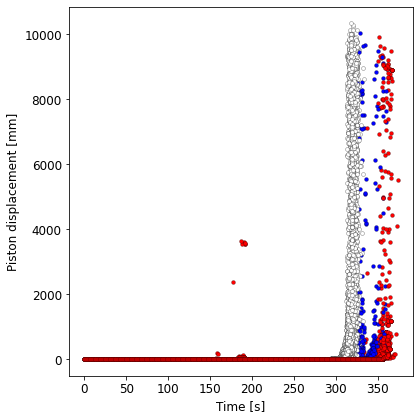

In [11]:
c = np.array(['white','blue','red'])

plt.subplots(figsize = (6.0,6.0))
for i in range(len(db['qualityAttribute'])):
  plt.scatter(db['time_samples_0'][i],db['samples_0'][i],c = c[db['qualityAttribute'][i]],\
              s = 15,edgecolor = 'black',linewidth = 0.25)
plt.xlabel('Time [s]')
plt.ylabel('Piston displacement [mm]')
plt.tight_layout()
plt.show()

In [12]:
stat = dict()

stat['qualityAttribute'] = np.array([],dtype = int)

for i in range(len(db['qualityAttribute'])):
  stat['qualityAttribute'] = np.append(stat['qualityAttribute'],int(db['qualityAttribute'][i]))

stat['max_time_samples_0'] = getMax(db['time_samples_0'])

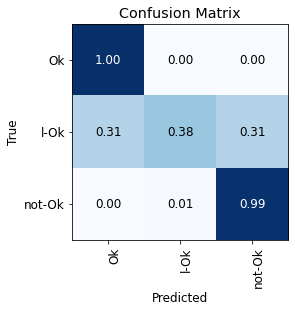

In [13]:
Xtrain,Xtest,ytrain,ytest = train_test_split(stat['max_time_samples_0'].reshape(-1,1),stat['qualityAttribute'], \
                                             random_state = 23,test_size = 0.5)

scaler = StandardScaler().fit(Xtrain)

clf = MLPClassifier(random_state = 23,max_iter = 1000).fit(scaler.transform(Xtrain),ytrain)
ypredict = clf.predict(scaler.transform(Xtest))

plotConfusionMatrix(ytest,ypredict,classes = ['Ok','l-Ok','not-Ok'])
plt.savefig('matrix-1.png',dpi = 300,format = 'png')
plt.show()

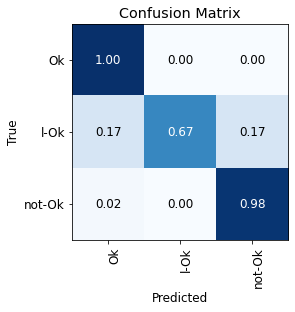

In [14]:
label = to_categorical(stat['qualityAttribute'])

Xtrain,Xtest,ytrain,ytest = train_test_split(stat['max_time_samples_0'].reshape(-1,1),label,\
                                             random_state = 23,test_size = 0.25)

scaler = StandardScaler().fit(Xtrain)

model = Sequential()

model.add(Dense(300,activation = 'relu',input_dim = 1))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(300,activation = 'relu'))
model.add(Dense(3,activation = 'softmax'))

model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',\
              metrics = ['accuracy'])

model.fit(scaler.transform(Xtrain),ytrain,epochs = 15,batch_size = 32,\
          verbose = 0)

plotConfusionMatrix(np.argmax(ytest,axis = -1),np.argmax(model.predict(scaler.transform(Xtest)),axis = -1),\
                    ['Ok','l-Ok','not-Ok'],
                    title = 'Confusion Matrix',cmap = plt.cm.Blues)
plt.savefig('matrix-2.png',dpi = 300,format = 'png')
plt.show()

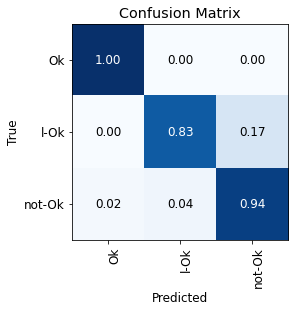

In [15]:
class_weight = {0: 5.0,1:200.0,2:100.0}

model.fit(scaler.transform(Xtrain),ytrain,epochs = 15,batch_size = 32,\
          class_weight = class_weight,\
          verbose = 0)

plotConfusionMatrix(np.argmax(ytest,axis = -1),np.argmax(model.predict(scaler.transform(Xtest)),axis = -1),\
                    ['Ok','l-Ok','not-Ok'],
                    title = 'Confusion Matrix',cmap = plt.cm.Blues)
plt.savefig('matrix-3.png',dpi = 300,format = 'png')
plt.show()